# Lab 7: Heterogeneous Effects

[Rely on Schrimpf notes *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  


**Outcomes**

- Understand potential outcomes and treatment effects  
- Apply generic machine learning inference to data from a randomized experiment  

In [ ]:
# Uncomment following line to install on colab
#! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes doubleml

In [1]:
import pandas as pd
import numpy as np
import patsy
from sklearn import linear_model, ensemble, base, neural_network
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler

import doubleml as dml

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we will learn how to apply machine learning methods to analyze
results of a randomized experiment. We typically begin analyzing
experimental results by calculating the difference in mean
outcomes between the treated and control groups. This difference estimates well
the average treatment effect. We can obtain more
nuanced results by recognizing that the effect of most experiments
might be heterogeneous. That is, different people could be affected by
the experiment differently. We will use machine learning methods to
explore this heterogeneity in treatment effects.

## Background and Data

We are going to use data from a randomized  experiment in Indonesia
called Program Keluarga Harapan (PKH). PKH was a conditional cash
transfer program designed to improve child health. Eligible pregnant
women would receive a cash transfer if they attended at least 4
pre-natal and 2 post-natal visits, received iron supplements, and had
their baby delivered by a doctor or midwife. The cash transfers were
given quarterly and were about 60-220 dollars or 15-20 percent of
quarterly consumption. PKH eligibility was randomly assigned at the
kecamatan (district) level. All pregnant women living in a treated
kecamatan could choose to participate in the experiment. 

We are using the data provided with [Triyana, Margaret. 2016. "Do Health Care Providers Respond to Demand-Side Incentives? Evidence from Indonesia." American Economic Journal: Economic Policy, 8 (4): 255-88.](https://www.aeaweb.org/articles?id=10.1257/pol.20140048).

In [2]:
df = pd.read_csv("Triyana_2016_price_women_clean.csv")
df.describe()

,rid_panel,prov,Location_ID,dist,wave,edu,agecat,log_xp_percap,rhr031,rhr032,...,hh_xp_all,tv,parabola,fridge,motorbike,car,pig,goat,cow,horse
count,1.225100e+04,22768.000000,2.277100e+04,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,...,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.00000,22771.000000,22771.000000
mean,3.406884e+12,42.761156,4.286882e+06,431842.012033,1.847174,52.765799,4.043081,13.420404,0.675157,0.754908,...,3.839181,0.754908,0.482148,0.498661,0.594792,0.470511,0.536691,0.53858,0.515041,0.470247
std,1.944106e+12,14.241982,1.423541e+06,143917.353784,0.875323,45.833778,1.280589,1.534089,0.468326,0.430151,...,1.481982,0.430151,0.499692,0.500009,0.490943,0.499141,0.498663,0.49852,0.499785,0.499125
min,1.100103e+10,31.000000,3.175010e+06,3524.000000,1.000000,6.000000,0.000000,7.461401,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.731008e+12,32.000000,3.210180e+06,323210.000000,1.000000,6.000000,3.000000,11.972721,0.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,3.491004e+12,35.000000,3.517171e+06,353517.000000,2.000000,12.000000,5.000000,12.851639,1.000000,1.000000,...,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000
75%,5.061008e+12,53.000000,5.307020e+06,535307.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,6.681013e+12,75.000000,7.571030e+06,757571.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [65]:
df.columns

Index(['rid_panel', 'prov', 'Location_ID', 'dist', 'wave', 'edu', 'agecat',
       'log_xp_percap', 'rhr031', 'rhr032',
       ...
       'hh_xp_all', 'tv', 'parabola', 'fridge', 'motorbike', 'car', 'pig',
       'goat', 'cow', 'horse'],
      dtype='object', length=121)

In [66]:
list(df)

['rid_panel',
 'prov',
 'Location_ID',
 'dist',
 'wave',
 'edu',
 'agecat',
 'log_xp_percap',
 'rhr031',
 'rhr032',
 'rhr034',
 'rhr036',
 'death_ch',
 'bw',
 'bw_low',
 'birthfac',
 'good_assisted_delivery',
 'doctor_birth',
 'midwife_birth',
 'traditional_birth',
 'delivery_fees',
 'delivery_fees_prof',
 'delivery_fees_doc',
 'delivery_fees_midw',
 'delivery_fees_trad',
 'control_pkh',
 'pkh_kec_ever',
 'pkh_ever',
 'bw_kec',
 'bw_low_kec',
 'death_ch_kec',
 'doctor_birth_base',
 'midwife_birth_base',
 'traditional_birth_base',
 'bid_pkh1',
 'bid_pkh1_base',
 'delivery_fees_top',
 'delivery_fees_prof_top',
 'delivery_fees_doc_top',
 'delivery_fees_midw_top',
 'delivery_fees_trad_top',
 'delivery_fees_top_base',
 'delivery_fees_prof_top_base',
 'delivery_fees_doc_top_base',
 'delivery_fees_midw_top_base',
 'delivery_fees_trad_top_base',
 'hh_serial_no_w1',
 'hh_survey_date_w1',
 'hh_adult',
 'hh_5_15',
 'hh_u5',
 'hh_serial_no_w2',
 'hh_serial_no_w3',
 'hh_u2',
 'hh_3_6',
 'hh_7_15',


## Potential Outcomes and Treatment Effects

Since program eligibility was randomly assigned (and what
policymakers could choose to change), we will focus on estimating
the effect of eligibility. We will let
$ d_i $ be a 1 if person $ i $ was eligible and be 0 if not.
Let $ y_i $ be an outcome of interest. Below, we
will look at **midwife usage** and **birth weight** as outcomes.

It is
useful to think about potential outcomes of the treatment. The potential treated
outcome is $ y_i(1) $. For subjects who actually were treated,
$ y_i(1) = y_i $ is the observed outcome. For untreated subjects,
$ y_i(1) $ is what mother i ‘s baby’s birth weight would have
been if she had been eligible for the program. Similarly, we can
define the potential untreated outcome $ y_i(0) $: what mother's i baby's birth weight would have been if she had not been eligible.

The individual treatment effect for subject i is $ y_i(1) - y_i(0) $.

As you know we can not observe individual i counterfactual in real life: she is eligible or not. Therefore, individual treatment effects are impossible to know since we always
only observe $ y_i(1) $ or $ y_i(0) $, but never both.

BUT when treatment is randomly assigned, we can estimate **average treatment
effects** because

$$
\begin{align*}
E[y_i(1) - y_i(0) ] = & E[y_i(1)] - E[y_i(0)] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1] - E[y_i(0) | d_i = 0] \\
= & E[y_i | d_i = 1] - E[y_i | d_i = 0 ]
\end{align*}
$$

### Average Treatment Effects

Let’s estimate the average treatment effect.

In [3]:
# some data prep for later: just preparing all the covariates
formula = """
bw ~ pkh_kec_ever +
  C(edu)*C(agecat) + log_xp_percap + hh_land + hh_home + C(dist) +
  hh_phone + hh_rf_tile + hh_rf_shingle + hh_rf_fiber +
  hh_wall_plaster + hh_wall_brick + hh_wall_wood + hh_wall_fiber +
  hh_fl_tile + hh_fl_plaster + hh_fl_wood + hh_fl_dirt +
  hh_water_pam + hh_water_mechwell + hh_water_well + hh_water_spring + hh_water_river +
  hh_waterhome +
  hh_toilet_own + hh_toilet_pub + hh_toilet_none +
  hh_waste_tank + hh_waste_hole + hh_waste_river + hh_waste_field +
  hh_kitchen +
  hh_cook_wood + hh_cook_kerosene + hh_cook_gas +
  tv + fridge + motorbike + car + goat + cow + horse
"""
# this create formula to display the results later on
bw, X = patsy.dmatrices(formula, df, return_type="dataframe")

# some categories are empty after dropping rows will Null, drop now
X = X.loc[:, X.sum() > 0]
bw = bw.iloc[:, 0]

#Define the treatment variable
treatment_variable = "pkh_kec_ever"
treatment = X["pkh_kec_ever"]

##Drop the treatment variable from the covariates array 
Xl = X.drop(["Intercept", "pkh_kec_ever", "C(dist)[T.313175]"], axis=1)
#Standardize the variable


loc_id = df.loc[X.index, "Location_ID"].astype("category")

import re
# remove [ ] from names for compatibility with xgboost
Xl = Xl.rename(columns=lambda x: re.sub('\[|\]','_',x))

In [4]:
# Estimate average treatment effects
from statsmodels.iolib.summary2 import summary_col

A breakdown of tmp dataframe
1. "birthweight": This column will contain the data from the bw variable or array.
2. "treatment": This column will contain the data from the treatment variable or array.
3. "assisted_delivery": This column will contain the data from the "good_assisted_delivery" column of the DataFrame df, using the index from X.

Then we estimate ATE on usage and birth weight

In [6]:
tmp = pd.DataFrame(dict(birthweight=bw,treatment=treatment,assisted_delivery=df.loc[X.index, "good_assisted_delivery"]))

usage = smf.ols("assisted_delivery ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})

health= smf.ols("bw ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})

In [70]:
print(usage.summary())

                            OLS Regression Results                            
Dep. Variable:      assisted_delivery   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.497
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.222
Time:                        09:51:08   Log-Likelihood:                -2626.7
No. Observations:                4988   AIC:                             5257.
Df Residuals:                    4986   BIC:                             5270.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7827      0.012     63.113      0.0

In [71]:
print(health.summary())

                            OLS Regression Results                            
Dep. Variable:                     bw   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3659
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.546
Time:                        09:51:28   Log-Likelihood:                -38649.
No. Observations:                4988   AIC:                         7.730e+04
Df Residuals:                    4986   BIC:                         7.732e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3173.4067     10.232    310.137      0.0

The program did not increase the percent of births assisted by a medical
professional nor birth weight.

### Conditional Average Treatment Effects

So far, every time we’ve estimated the causal impact of a treatment, it was the average treatment effect (or, sometimes, the local average treatment effect). ATE estimation is the bedrock of causal inference. It’s a super useful tool for the decision making problem we refer to as program evaluation. 

Now, we will try to inform another type of decision: who do we treat? Who benefits the most of an intervention? 
Although we can never estimate individual treatment effects, the logic that lets us estimate unconditional average treatment effects also suggests that we can estimate conditional average treatment effects (CATE).

The conditioning on means that we now allow the treatment effect to be different depending on the characteristics of each individual. Again, here, we believe that not all entities respond equally well to the treatment and want to estimate this heterogeneity.

$$
\begin{align*}
E[y_i(1) - y_i(0) |X_i=x] = & E[y_i(1)|X_i = x] - E[y_i(0)|X_i=x] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1, X_i=x] - E[y_i(0) | d_i = 0, X_i=x] \\
= & E[y_i | d_i = 1, X_i = x] - E[y_i | d_i = 0, X_i=x ]
\end{align*}
$$

Conditional average treatment effects tell us whether there are identifiable (by X) groups of people for with varying treatment effects vary.

Since conditional average treatment effects involve conditional expectations, machine learning methods might be useful.

However, if we want to be able to perform statistical inference, we must use machine learning methods carefully. We will detail two approaches.

## Generic Machine Learning Inference

In this section, we will describe the “generic machine learning
inference” method of [Chernozhukov et al. (2018)](https://www.nber.org/papers/w24678) to explore heterogeneity in
conditional average treatment effects.

This approach allows any
machine learning method to be used to estimate $ E[y_i(1) -
y_i(0) |X_i=x] $.

Inference for functions estimated by machine learning methods is
typically either impossible or requires very restrictive assumptions.
They overcome this issue by focusing on inference for
certain summary statistics of the machine learning prediction for
$ E[y_i(1) - y_i(0) |X_i=x] $ rather than $ E[y_i(1) - y_i(0) |X_i=x] $ itself.

### Best Linear Projection of CATE

Let $ s_0(x) = E[y_i(1) - y_i(0) |X_i=x] $ denote the true
conditional average treatment effect. Let $ S(x) $ be an estimate
or noisy proxy for $ s_0(x) $. One way to summarize how well
$ S(x) $ approximates $ s_0(x) $ is to look at the best linear
projection of $ s_0(x) $ on $ S(x) $.

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\beta_0, \beta_1 = \argmin_{b_0,b_1} E[(s_0(x) -
b_0 - b_1 (S(x)-E[S(x)]))^2]
$$

$ \beta_0 = E[y_i(1) - y_i(0)] $ is the unconditional average treatment effect. 

Focus on $ \beta_1 $, which is related to how well $ S(x) $ approximates $ s_0(x) $. If $ S(x) = s_0(x) $, then $ \beta_1=1 $. If $ S(x) $ is completely uncorrelated with $ s_0(x) $, then $ \beta_1 = 0 $.

The best linear projection of the conditional average treatment effect tells us something about how well $ S(x) $ approximates $ s_0(x) $, **but** does nothing to estimate how the CATE varies with $ x $. We could try looking
at $ S(x) $ directly, but if $ x $ is high dimensional, reporting or visualizing
$ S(x) $ will be difficult. Moreover, most machine learning methods have no satisfactory method to determine inferences
on $ S(x) $. This is very problematic if we want to use
$ S(x) $ to shape future policy decisions. For example, we might
want to use $ S(x) $ to target the treatment to people with
different $ x $. If we do this, we need to know whether the
estimated differences across $ x $ in $ S(x) $ are precise or
caused by noise.

### Grouped Average Treatment Effects

To deal with both these issues, they focus
grouped average treatment effects (GATE) with groups defined by
$ S(x) $. Partition the data into a fixed, finite number of groups
based on $ S(x) $ . The intuition is to look at heterogeneity across group differentially affected

Let $ G_{k}(x) = 1\{\ell_{k-1} \leq S(x) \leq \ell_k \} $ where
$ \ell_k $ could be a constant you can choose or evenly
spaced quantiles of $ S(x) $. The $ k $ th grouped average
treatment effect is then $ \gamma_k = E[y(1) - y(0) | G_k(x)] $.

If the **true $ s_0(x) $ is not constant**, and $ S(x) $
approximates $ s_0(x) $ well, then the *grouped average treatment
effects will increase* with $ k $. 

If the **CATE
has no heterogeneity** (i.e. $ s_0(x) $ is constant) and/or
$ S(x) $ is a poor approximation to $ s_0(x) $,
then the *grouped average treatment effect will tend to
be constant* with $ k $ and may even be non-monotonic due to
estimation error.

### Estimation

We can estimate both the best linear projection of the conditional average treatment
effect and the grouped treatment effects by using
particular regressions. Let $ B(x) $ be an estimate of the outcome
conditional on no treatment, i.e. $ B(x) = \widehat{E[y(0)|x]} $
. Then the estimates of $ \beta $ from the regression

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \beta_0 (d_i-P(d=1)) + \beta_1
(d_i-P(d=1))(S(x_i) - E[S(x_i)]) + \epsilon_i
$$

are consistent estimates of the best linear projection of the
conditional average treatment effect if $ B(x_i) $ and
$ S(x_i) $ are uncorrelated with $ y_i $ . We can ensure that
$ B(x_i) $ and $ S(x_i) $ are uncorrelated with $ y_i $ by
using the familiar idea of sample-splitting and cross-validation. The
usual regression standard errors will also be valid.

Similarly, we can estimate grouped average treatment effects from the
following regression.

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \sum_k \gamma_k (d_i-P(d=1)) 1(G_k(x_i)) +
u_i
$$

The resulting estimates of $ \gamma_k $ will be consistent and
asymptotically normal with the usual regression standard errors.

In [13]:
# for clustering standard errors
def get_treatment_se(fit, cluster_id, rows=None):
    if cluster_id is not None:
        if rows is None:
            rows = [True] * len(cluster_id)
        vcov = sm.stats.sandwich_covariance.cov_cluster(fit, cluster_id.loc[rows])
        return np.sqrt(np.diag(vcov))

    return fit.HC0_se

In [14]:
def generic_ml_model(x, y, treatment, model, n_split=10, n_group=5, cluster_id=None):
    nobs = x.shape[0]

    blp = np.zeros((n_split, 2))
    blp_se = blp.copy()
    gate = np.zeros((n_split, n_group))
    gate_se = gate.copy()

    baseline = np.zeros((nobs, n_split))
    cate = baseline.copy()
    lamb = np.zeros((n_split, 2))

    for i in range(n_split):
        main = np.random.rand(nobs) > 0.5
        rows1 = ~main & (treatment == 1)
        rows0 = ~main & (treatment == 0)

        mod1 = base.clone(model).fit(x.loc[rows1, :], (y.loc[rows1]))
        mod0 = base.clone(model).fit(x.loc[rows0, :], (y.loc[rows0]))

        B = mod0.predict(x)
        S = mod1.predict(x) - B
        baseline[:, i] = B
        cate[:, i] = S
        ES = S.mean()

        ## BLP
        # assume P(treat|x) = P(treat) = mean(treat)
        p = treatment.mean()
        reg_df = pd.DataFrame(dict(
            y=y, B=B, treatment=treatment, S=S, main=main, excess_S=S-ES
        ))
        reg = smf.ols("y ~ B + I(treatment-p) + I((treatment-p)*(S-ES))", data=reg_df.loc[main, :])
        reg_fit = reg.fit()
        blp[i, :] = reg_fit.params.iloc[2:4]
        blp_se[i, :] = get_treatment_se(reg_fit, cluster_id, main)[2:]

        lamb[i, 0] = reg_fit.params.iloc[-1]**2 * S.var()

        ## GATEs
        cutoffs = np.quantile(S, np.linspace(0,1, n_group + 1))
        cutoffs[-1] += 1
        for k in range(n_group):
            reg_df[f"G{k}"] = (cutoffs[k] <= S) & (S < cutoffs[k+1])

        g_form = "y ~ B + " + " + ".join([f"I((treatment-p)*G{k})" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=reg_df.loc[main, :])
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.values[2:] #g_fit.params.filter(regex="G").values
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, main)[2:]

        lamb[i, 1] = (gate[i,:]**2).sum()/n_group

    out = dict(
        gate=gate, gate_se=gate_se,
        blp=blp, blp_se=blp_se,
        Lambda=lamb, baseline=baseline, cate=cate,
        name=type(model).__name__
    )
    return out


def generic_ml_summary(generic_ml_output):
    out = {
        x: np.nanmedian(generic_ml_output[x], axis=0)
        for x in ["blp", "blp_se", "gate", "gate_se", "Lambda"]
    }
    out["name"] = generic_ml_output["name"]
    return out

In [15]:
kw = dict(x=Xl, treatment=treatment, n_split=11, n_group=5, cluster_id=loc_id)

In [16]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate_models(models, y, **other_kw):
    all_kw = kw.copy()
    all_kw["y"] = y
    all_kw.update(other_kw)
    return list(map(lambda x: generic_ml_model(model=x, **all_kw), models))

In [17]:
def generate_report(results):
    summaries = list(map(generic_ml_summary, results))
    df_plot = pd.DataFrame({
        mod["name"]: np.median(mod["cate"], axis=1)
        for mod in results
    })

    print("Correlation in median CATE:")
    display(df_plot.corr())
    sns.pairplot(df_plot, diag_kind="kde", kind="reg")

    print("\n\nBest linear projection of CATE")
    df_cate = pd.concat({
        s["name"]: pd.DataFrame(dict(blp=s["blp"], se=s["blp_se"]))
        for s in summaries
    }).T.stack()
    display(df_cate)

    print("\n\nGroup average treatment effects:")
    df_groups = pd.concat({
        s["name"]: pd.DataFrame(dict(gate=s["gate"], se=s["gate_se"]))
        for s in summaries
    }).T.stack()
    display(df_groups)

In [18]:
models = [
    linear_model.LassoCV(cv=10, n_alphas=25, max_iter=500, tol=1e-4, n_jobs=1),
    ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=20),
]

### Birth weight

Now let's look whether we observe any heterogeneity in treatment effect for birth weight

In [19]:
results = evaluate_models(models, y=bw)

C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

Correlation in median CATE:


,LassoCV,RandomForestRegressor
LassoCV,1.000000,0.446254
RandomForestRegressor,0.446254,1.000000


C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv



Best linear projection of CATE


LassoCV  RandomForestRegressor
blp 0 -26.322403             -19.723790
    1   0.150480               0.071156
se  0  31.860040              33.174828
    1   0.749948               0.282585



Group average treatment effects:


LassoCV  RandomForestRegressor
gate 0 -13.275953             -28.341951
     1   0.000000             -12.974557
     2   0.000000             -63.860001
     3  -4.525866             -32.412168
     4   4.209028              -3.560840
se   0  65.935244              70.278373
     1  62.831494              66.959079
     2  72.306268              72.277669
     3  68.520568              71.221850
     4  71.716329              74.062431

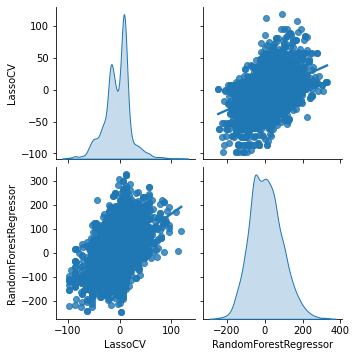

In [20]:
generate_report(results)

From the second table above, we see that regardless of the machine
learning method, the estimated intercept (the first row of the table)
is near 0 and statistically insignificant. Given our results for the unconditional
ATE above, we should expect this. The estimate of the
slopes are also either near 0, very imprecise, or both. This means
that either the conditional average treatment effect is near 0 or that all
four machine learning methods are very poor proxies for the true
conditional average treatment effect.

### Assisted Delivery

Let’s see what we get when we look at assisted delivery.

In [21]:
ad = df.loc[X.index, "good_assisted_delivery"]#"midwife_birth"]
results_ad = evaluate_models(models, y=ad)

C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

Correlation in median CATE:


,LassoCV,RandomForestRegressor
LassoCV,1.00000,0.85439
RandomForestRegressor,0.85439,1.00000


C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv



Best linear projection of CATE


LassoCV  RandomForestRegressor
blp 0  0.047818               0.040285
    1  0.490843               0.500071
se  0  0.021302               0.021541
    1  0.145511               0.148306



Group average treatment effects:


LassoCV  RandomForestRegressor
gate 0 -0.046987              -0.034145
     1 -0.011648               0.001317
     2 -0.027110               0.004717
     3  0.092918               0.065714
     4  0.185048               0.197014
se   0  0.041770               0.049147
     1  0.040439               0.045526
     2  0.046532               0.045126
     3  0.042507               0.046434
     4  0.053174               0.053034

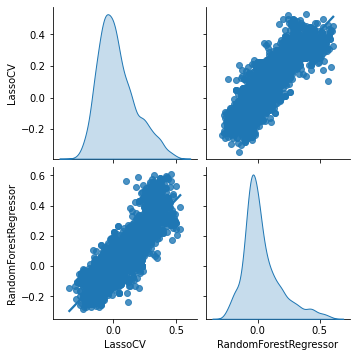

In [22]:
generate_report(results_ad)

For all four machine learning
methods, the slope estimate is positive and statistically
significant. From this, we can conclude that the true conditional
average treatment effect must vary with at least some covariates, and
the machine learning proxies are at least somewhat correlated with the
true conditional average treatment effect.

### Covariate Means by Group

Once we’ve detected heterogeneity in the grouped average treatment effects
of using medical professionals for assisted delivery, it’s interesting to see
how effects vary across groups. 

In [26]:
df2 = df.loc[X.index, :]
df2["edu99"] = df2.edu == 99
df2["educ"] = df2["edu"]
df2.loc[df2["edu99"], "educ"] = np.nan

variables = [
    "log_xp_percap","agecat","educ","tv","goat",
    "cow","motorbike","hh_cook_wood","pkh_ever"
]

In [23]:
def cov_mean_by_group(y, res, cluster_id):
    n_group = res["gate"].shape[1]
    gate = res["gate"].copy()
    gate_se = gate.copy()
    dat = y.to_frame()

    for i in range(res["cate"].shape[1]):
        S = res["cate"][:, i]
        cutoffs = np.quantile(S, np.linspace(0, 1, n_group+1))
        cutoffs[-1] += 1
        for k in range(n_group):
            dat[f"G{k}"] = ((cutoffs[k] <= S) & (S < cutoffs[k+1])) * 1.0

        g_form = "y ~ -1 + " + " + ".join([f"G{k}" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=dat.astype(float))
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.filter(regex="G").values
        rows = ~y.isna()
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, rows)

    out = pd.DataFrame(dict(
        mean=np.nanmedian(gate, axis=0),
        se=np.nanmedian(gate_se, axis=0),
        group=list(range(n_group))
    ))

    return out

In [24]:
def compute_group_means_for_results(results):
    to_cat = []
    for res in results:
        for v in variables:
            to_cat.append(
                cov_mean_by_group(df2[v], res, loc_id)
                .assign(method=res["name"], variable=v)
            )

    group_means = pd.concat(to_cat, ignore_index=True)
    group_means["plus2sd"] = group_means.eval("mean + 1.96*se")
    group_means["minus2sd"] = group_means.eval("mean - 1.96*se")
    return group_means

In [27]:
group_means_ad = compute_group_means_for_results(results_ad)

C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


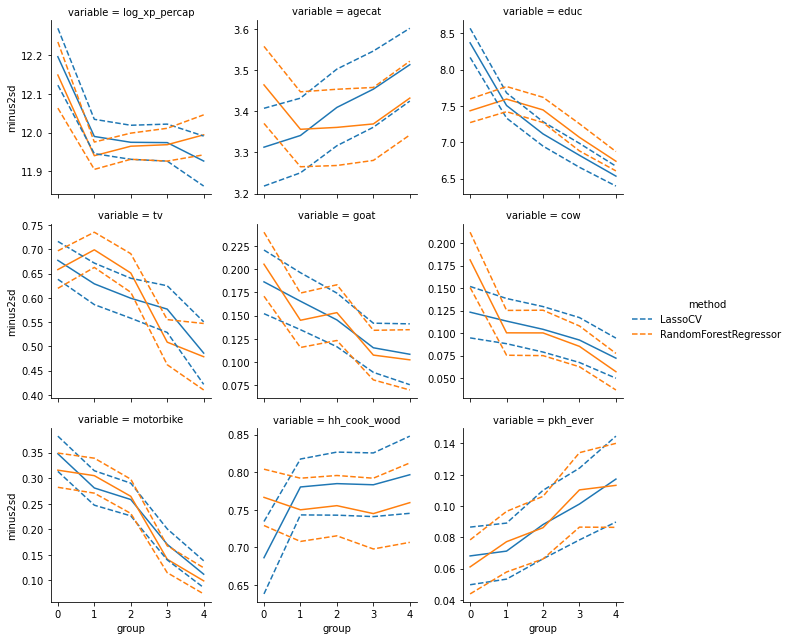

In [28]:
g = sns.FacetGrid(group_means_ad, col="variable", col_wrap=3, hue="method", sharey=False)
g.map(plt.plot, "group", "mean")
g.map(plt.plot, "group", "plus2sd", ls="--")
g.map(plt.plot, "group", "minus2sd", ls="--")
g.add_legend();

From this, we see that the group predicted to be most affected by treatment
are less educated, less likely to own a TV or
motorbike, and more likely to participate in the program.

If we wanted to maximize the program impact with a limited budget, targeting the program towards
less educated and less wealthy mothers could be a good idea. The existing financial incentive
already does this to some extent. As one might expect, a fixed-size
cash incentive has a bigger behavioral impact on less wealthy
individuals. If we want to further target these individuals, we
could alter eligibility rules and/or increase the cash transfer
for those with lower wealth.

## Causal Trees and Forests

Athey and Imbens (2016) develop the idea of “causal trees.” The purpose and
method are qualitatively similar to the grouped average treatment
effects. The main difference is that the groups in Athey and Imbens (2016)
are determined by a low-depth regression tree instead of by quantiles
of a noisy estimate of the conditional average treatment effect. As
above, sample-splitting is used to facilitate inference.

Causal trees share many downsides of regression trees. In
particular, the branches of the tree and subsequent results can be
sensitive to small changes in the data.  Athey and Wager (2018)  develop a
causal forest estimator to address this concern. This causal forest
estimates $ E[y_i(1) - y_i(0) |X_i=x] $ directly. Unlike most
machine learning estimators, they prove that causal
forests are consistent and pointwise asymptotically normal, albeit
with a slower than $ \sqrt{n} $ rate of convergence. In practice,
this means that either the sample size must be very large (and/or $ x $
relatively low dimension) to get precise estimates.

## Random Causal Forest


In [ ]:
# Install econml
%pip install econml #&> /dev/null

In [87]:
# NOTE: If you are getting `np.int` error, do the following:
# pip install --force-reinstall numpy==1.23.5
# There is a fix for the new numpy version, but it's not released yet:
# https://github.com/py-why/EconML/commit/0be16255f10853fc9fe0774cb5649e051dc55dff


In [35]:
data = pd.read_csv(
    "https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/data/jtpahet.csv"
)
data

,age,enroll,priorearn,educ,female,nonwhite,z,married,foundjob
0,46,1,0,12,1,1,1,0,1
1,24,1,3591,11,1,0,1,0,1
2,28,1,6000,9,0,1,1,1,1
3,23,0,2000,11,0,0,0,1,1
4,34,0,0,12,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
13848,26,0,0,12,1,1,0,1,0
13849,52,0,0,10,0,0,1,0,0
13850,32,0,0,12,1,1,0,0,0
13851,16,1,0,9,0,1,1,0,0


In [36]:
y = data["foundjob"]
z = data["z"]
x = data.drop(["foundjob", "z", "enroll"], axis=1)


,age,priorearn,educ,female,nonwhite,married
0,46,0,12,1,1,0
1,24,3591,11,1,0,0
2,28,6000,9,0,1,1
3,23,2000,11,0,0,1
4,34,0,12,1,1,1
...,...,...,...,...,...,...
13848,26,0,12,1,1,1
13849,52,0,10,0,0,0
13850,32,0,12,1,1,0
13851,16,0,9,0,1,0


### Regression to get average effect
Run a linear regression of the outcome on the random assignment indicator. Since this was a randomized experiment, we don't need controls!


In [75]:
df = pd.DataFrame(dict(treatment=z,y=data.loc[x.index, "foundjob"]))
usage = smf.ols("y ~ treatment", data=df).fit(cov_type="HC3")
print(usage.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.691
Date:                Thu, 07 Dec 2023   Prob (F-statistic):            0.00556
Time:                        10:08:05   Log-Likelihood:                -5663.4
No. Observations:               13853   AIC:                         1.133e+04
Df Residuals:                   13851   BIC:                         1.135e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8297      0.006    146.446      0.0

### Group Average Treatment Effects (GATEs)

Here, we consider 4 different groups which depend on age, which  correspond to 4 different age groups in the sample. 

The first step is to fit a DoubleML IRM Model to the data.

In [ ]:
import doubleml as dml
covariates = list(x.columns.values)

data_dml_base = dml.DoubleMLData(data,
                                 y_col='foundjob',
                                 d_cols='z',
                                 x_cols=covariates)

C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [ ]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)

Training IRM Model


C:\Users\jdnmiguel\Dropbox\Class\envpygis\lib\site-packages\doubleml\_utils_checks.py:204: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [ ]:
data.describe()

,age,enroll,priorearn,educ,female,nonwhite,z,married,foundjob
count,13853.000000,13853.000000,13853.000000,13853.000000,13853.000000,13853.000000,13853.000000,13853.000000,13853.000000
mean,29.297336,0.455064,2820.995236,11.492384,0.559085,0.437667,0.682091,0.271277,0.842489
std,10.575514,0.497995,3998.424767,1.791638,0.496515,0.496117,0.465681,0.444635,0.364295
min,16.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,1190.000000,12.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,35.000000,1.000000,4200.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,82.000000,1.000000,57427.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next, we can specify the groups as DataFrame with boolean columns based on age.



In [68]:
groups = pd.DataFrame(np.column_stack([data['age'] <= 21,
                                       (data['age'] > 21) & (data['age'] <= 27),
                                       (data['age'] > 27)  & (data['age'] <=35),
                                       data['age']>35]),
             columns=['Group 1', 'Group 2', 'Group 3', 'Group 4'])

To calculate GATEs just call the gate() method and supply the DataFrame with the group definitions and the level (with default of 0.95).



In [69]:
gate = dml_irm.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1 -0.090068  0.065815  0.221697
Group 2 -0.072059  0.051355  0.174770
Group 3 -0.098103  0.045547  0.189196
Group 4 -0.077880  0.074581  0.227041


The confidence intervals above are point-wise, but by setting the option joint and providing a number of bootstrap repetitions n_rep_boot.

In [70]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1 -0.206288  0.065815  0.337918
Group 2 -0.164072  0.051355  0.266783
Group 3 -0.205202  0.045547  0.296296
Group 4 -0.191549  0.074581  0.340710


Finally, let us plot the estimates together with the true effect within each group.

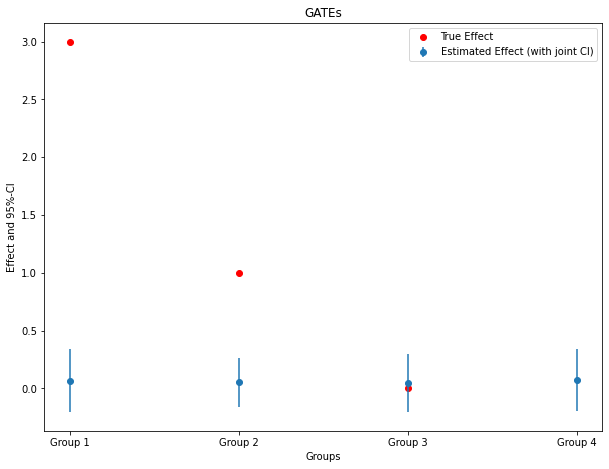

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=[3, 1, 0], c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

### Set up random forest


In [136]:
from econml.dml import CausalForestDML as CausalForest

In [31]:
os.getcwd()

'C:\\Users\\jdnmiguel\\Documents\\GitHub\\Applied-ML\\Code'

In [30]:
import os

So far, so good? Now create a random causal forest object, and fit it with outcome `y`, treatment variable `z`, and feature matrix `x`.


In [135]:
rcf = CausalForest(n_estimators=1000, discrete_treatment=True, criterion="het").fit(
    y, z, X=x
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want t

### Explore effects


Let's see what kind of heterogeneous effects our random causal forest predicted


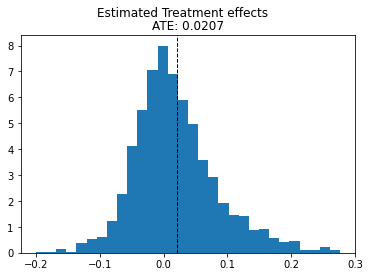

In [137]:
# calculate the predicted effects:
insamplefx = rcf.effect(x)
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()
ax.hist(insamplefx, bins=30, density=True)
plt.axvline(rcf.ate_, color="k", linestyle="dashed", linewidth=1)
plt.suptitle("Estimated Treatment effects")
plt.title("ATE: {:.3g}".format(rcf.ate_[0]))
plt.show()

Let's visualize how these effects vary by prior earnings and education by making a heatmap


In [139]:
import itertools

In [140]:
# create a grid of values for education and prior earnings:
educgrid = np.arange(data["educ"].values.min(), data["educ"].values.max() + 1)
earngrid = np.arange(
    data["priorearn"].values.min(), data["priorearn"].values.max(), 5000
)
grid = pd.DataFrame(
    itertools.product(educgrid, earngrid), columns=["educ", "priorearn"]
)

We'll first visualize the effects among married, nonwhite females of average age:


In [148]:
grid["age"] = data["age"].values.mean()  # set age to the average
grid["female"] = 1  # set female = 1
grid["nonwhite"] = 1  # set nonwhite = 1
grid["married"] = 1  # set married = 1

In [149]:
gridfx = rcf.effect(grid)

Let's see the effects with a heat map

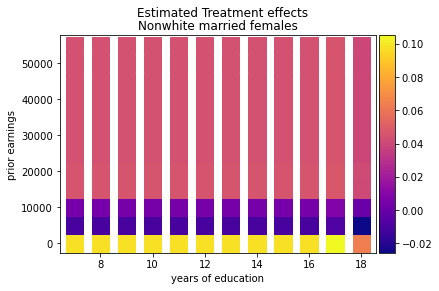

In [150]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = plt.subplot()
main = ax.scatter(
    grid["educ"], grid["priorearn"], c=gridfx, cmap="plasma", marker="s", s=300
)
plt.suptitle("Estimated Treatment effects")
plt.title("Nonwhite married females")
plt.xlabel("years of education")
plt.ylabel("prior earnings")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(main, cax=cax)
plt.show()